In [31]:
import os
import torch
import numpy as np
import torch.nn as nn
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score ,f1_score , confusion_matrix
import seaborn as sns
import re

Loading and Reading Data

In [3]:
from google.colab import files

uploaded = files.upload()

Saving mtsamples.csv to mtsamples.csv


In [4]:
df_medical = pd.read_csv("mtsamples.csv")
df_medical.head()

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


# Data pre-processing



1.   Removing the duplicates items
2.   Removing Null Values
3.   Only taking "Transcription" and "medical_speciality" columns
4.   Cleaning the texts in "Transcription" column
        *   removing non-alphabetical characters
        *   removing extra space
        *   converting text to lowercase







In [5]:
df_medical.drop_duplicates()
df_medical.isnull().sum()

Unnamed: 0              0
description             0
medical_specialty       0
sample_name             0
transcription          33
keywords             1068
dtype: int64

In [6]:
df_medical = df_medical.loc[:,["transcription", "medical_specialty"]]
df = df_medical[~(df_medical['transcription'].isnull()) &
                        ~(df_medical['medical_specialty'].isnull()) ]
df.shape

(4966, 2)

In [7]:
def clean_text(text):
    # Remove non-alphabetic characters
    cleaned_text = re.sub(r'[^a-zA-Z\s]', '', text)
    # replace whitespaces longer than 2
    cleaned_text = re.sub(r"\s{2,}", " ", cleaned_text)
    # strip any whitespace on the sides of text
    cleaned_text = cleaned_text.strip()

    # Convert to lowercase
    cleaned_text = cleaned_text.lower()

    return cleaned_text

In [8]:
df['transcription'] = df['transcription'].apply(clean_text)
df['medical_specialty'] = df['medical_specialty'].str.strip()

<ipython-input-8-4fd2531ec2cb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['transcription'] = df['transcription'].apply(clean_text)
<ipython-input-8-4fd2531ec2cb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['medical_specialty'] = df['medical_specialty'].str.strip()


# Understanding and Visualizing Data


*   **Visualizing the length of transcriptions**:- The length of the transcription ranges between 0 and 1700
  *  66% of transcption have length less than 500 words
  *  94.7% of transcption have length less than 1000 words



*  Visualizing Labels:-
  * There are 40 numbers of unique categories in medical_speciality
  * Dataset is highly imbalanced. Some categories like 'Surgery','Consult - History and Phy.', 'Orthopedic' have more than 350 samples while categories like 'Diets and Nutritions' , 'Autopsy' have less than  10 samples.

  * some categories like 'Office Notes', 'Letters ', 'SOAP / Chart / Progress Notes' are not medical specialities

  * some categorie are subsets of some other categories like 'Neurosurgery'is subset of 'Surgery'
  * categories like neurosurgery and neurology are overlaping to each other
  * All this suggest that data is very noisy

















<ipython-input-9-de1803be7fc0>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(trans_lengths)


<Axes: xlabel='transcription', ylabel='Density'>

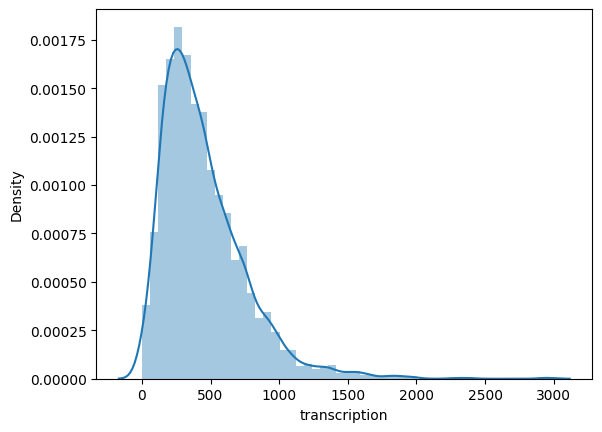

In [9]:
trans_lengths = df['transcription'].apply(lambda x: len(str(x).split()))
sns.distplot(trans_lengths)

In [12]:
def data_under_length(threshold, trans_lengths):
    count = 0
    for i in trans_lengths:
        if i <= threshold:
            count +=1

    return (count/len(trans_lengths))*100

In [13]:
# Percentage of transcriptions having length less than 500
data_under_length(500,trans_lengths)

65.98872331856626

In [14]:
# Percentage of transcriptions having length less than 1000
data_under_length(1000,trans_lengths)

94.74426097462747

In [15]:
print("No of unique lables:", df['medical_specialty'].nunique())

No of unique lables: 40


In [16]:
# Class Lebels with their count
df['medical_specialty'].value_counts()


Surgery                          1088
Consult - History and Phy.        516
Cardiovascular / Pulmonary        371
Orthopedic                        355
Radiology                         273
General Medicine                  259
Gastroenterology                  224
Neurology                         223
SOAP / Chart / Progress Notes     166
Urology                           156
Obstetrics / Gynecology           155
Discharge Summary                 108
ENT - Otolaryngology               96
Neurosurgery                       94
Hematology - Oncology              90
Ophthalmology                      83
Nephrology                         81
Emergency Room Reports             75
Pediatrics - Neonatal              70
Pain Management                    61
Psychiatry / Psychology            53
Office Notes                       50
Podiatry                           47
Dermatology                        29
Cosmetic / Plastic Surgery         27
Dentistry                          27
Letters     

###Loading Model and Tokenizer .

Used pre-trained Roberta base model. Base model has input capacity of 512 token while large model has capacity of 1024. Due to compute power and time limitation used base model.

In [17]:
# Set up the RoBERTa model and tokenizer
model_name = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=len(df['medical_specialty'].unique()))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

# Dataset creation for Training


*   Label encoding:- Tranformed the string class lebels to integer value


*   Train_Test Split:- The data was shuffled before being divided into training (80%) and testing (20%) sets.
*   Label mapping:- is done to retrieve the class name(string) given the class encoding(int)

*  DataLoader for model



In [18]:
# Initialize the LabelEncoder and fit_transform your labels
label_encoder = LabelEncoder()
df['medical_specialty'] = label_encoder.fit_transform(df['medical_specialty'])

<ipython-input-18-240f92b39d14>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['medical_specialty'] = label_encoder.fit_transform(df['medical_specialty'])


In [19]:
# Shuffle dataset
df = shuffle(df, random_state= 42)
# Split the dataset into training and testing sets

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Reset indices after splitting
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [20]:
test_labels = label_encoder.inverse_transform(test_df['medical_specialty'])

test_label_mapping ={}
j=0
for i in test_df['medical_specialty']:
    test_label_mapping[i] = test_labels[j]
    j += 1

In [21]:
len(test_label_mapping)

39

In [22]:
# will be used in evalution while making classification Report
target_names = []
for i in range(len(test_label_mapping)+1):
    label = test_label_mapping.get(i)# Replace "Key not found" with your desired default value
    if label:
        target_names.append(label)

In [23]:
target_names

['Allergy / Immunology',
 'Autopsy',
 'Bariatrics',
 'Cardiovascular / Pulmonary',
 'Chiropractic',
 'Consult - History and Phy.',
 'Cosmetic / Plastic Surgery',
 'Dentistry',
 'Dermatology',
 'Diets and Nutritions',
 'Discharge Summary',
 'ENT - Otolaryngology',
 'Emergency Room Reports',
 'Endocrinology',
 'Gastroenterology',
 'General Medicine',
 'Hematology - Oncology',
 'IME-QME-Work Comp etc.',
 'Lab Medicine - Pathology',
 'Letters',
 'Nephrology',
 'Neurology',
 'Neurosurgery',
 'Obstetrics / Gynecology',
 'Office Notes',
 'Ophthalmology',
 'Orthopedic',
 'Pain Management',
 'Pediatrics - Neonatal',
 'Physical Medicine - Rehab',
 'Podiatry',
 'Psychiatry / Psychology',
 'Radiology',
 'Rheumatology',
 'SOAP / Chart / Progress Notes',
 'Sleep Medicine',
 'Speech - Language',
 'Surgery',
 'Urology']

In [24]:
# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            padding='max_length',
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [25]:
# Set up training and testing datasets
max_len = 512
# Set up training and testing datasets
train_dataset = CustomDataset(train_df['transcription'], train_df['medical_specialty'], tokenizer, max_len)
test_dataset = CustomDataset(test_df['transcription'], test_df['medical_specialty'], tokenizer, max_len)


In [26]:
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Traning and Evaluation

In [27]:
# Set up optimizer and loss function

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#model.to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()
# Training loop
num_epochs = 3


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Code for Weighted loss function

In [ ]:
#from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
#class_weights = compute_class_weight('balanced', classes=np.unique(train_df['medical_specialty']), y=train_df['medical_specialty'])
#class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Set up the weighted loss function
#criterion = nn.CrossEntropyLoss(weight=class_weights)

Code to Train the model

In [28]:
def train_model():
    for epoch in range(num_epochs):
        print("Processing Epoch :" , epoch)
        model.train()
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()

Code for Evaluation

In [34]:
def evaluate_on_test():
    model.eval()
    with torch.no_grad():
        all_labels = []
        all_logits = []
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            all_labels.extend(labels.cpu().numpy())
            all_logits.extend(logits.cpu().numpy())

        # Convert logits to predicted labels
        predicted_labels = np.argmax(all_logits, axis=1)


    # Generate classification report
    unique_labels = np.unique(all_labels)
    report = classification_report(all_labels, predicted_labels, labels=unique_labels, target_names=target_names)
    accuracy = accuracy_score(all_labels, predicted_labels)
    #f1 = f1_score(all_labels, predicted_labels)
    print('accuracy score :', accuracy)
    #print(f1)
    #print(confusion_matrix(all_labels, predicted_labels))

    print(report)


## Results using Roberta-base model

Evaluating on pre-trained model.

In [35]:
# Evaluation on pre-trained model
evaluate_on_test()

accuracy score : 0.06338028169014084
                               precision    recall  f1-score   support

         Allergy / Immunology       0.00      0.00      0.00         1
                      Autopsy       0.00      0.00      0.00         1
                   Bariatrics       0.00      0.00      0.00         6
   Cardiovascular / Pulmonary       0.00      0.00      0.00        63
                 Chiropractic       0.00      0.00      0.00         3
   Consult - History and Phy.       0.00      0.00      0.00       105
   Cosmetic / Plastic Surgery       0.00      0.00      0.00         5
                    Dentistry       0.00      0.00      0.00         6
                  Dermatology       0.00      0.00      0.00         6
         Diets and Nutritions       0.00      0.00      0.00         2
            Discharge Summary       0.00      0.00      0.00        30
         ENT - Otolaryngology       0.00      0.00      0.00        26
       Emergency Room Reports       0.0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fine-Tune Roberta-base model

In [36]:
#Train the model
train_model()

Processing Epoch : 0
Processing Epoch : 1
Processing Epoch : 2


In [37]:
# evaluate fine-tuned model
evaluate_on_test()

accuracy score : 0.3631790744466801
                               precision    recall  f1-score   support

         Allergy / Immunology       0.00      0.00      0.00         1
                      Autopsy       0.00      0.00      0.00         1
                   Bariatrics       0.00      0.00      0.00         6
   Cardiovascular / Pulmonary       0.40      0.60      0.48        63
                 Chiropractic       0.00      0.00      0.00         3
   Consult - History and Phy.       0.28      0.32      0.30       105
   Cosmetic / Plastic Surgery       0.00      0.00      0.00         5
                    Dentistry       0.00      0.00      0.00         6
                  Dermatology       0.00      0.00      0.00         6
         Diets and Nutritions       0.00      0.00      0.00         2
            Discharge Summary       0.46      0.60      0.52        30
         ENT - Otolaryngology       0.50      0.08      0.13        26
       Emergency Room Reports       0.00

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## MedBERT
MedBERT is a transformer-based language model designed for biomedical named entity recognition.  

In [38]:
# Load MedBERT tokenizer and model
model_name = 'Charangan/MedBERT'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=len(df['medical_specialty'].unique()))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/417 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/669k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/682 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Charangan/MedBERT and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [39]:
# Set up training and testing datasets
max_len = 512
# Set up training and testing datasets
train_dataset = CustomDataset(train_df['transcription'], train_df['medical_specialty'], tokenizer, max_len)
test_dataset = CustomDataset(test_df['transcription'], test_df['medical_specialty'], tokenizer, max_len)


In [40]:
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [41]:
# Set up optimizer and loss function

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()
# Training loop
num_epochs = 3

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [42]:
# Evaluation on pre-trained model
evaluate_on_test()

accuracy score : 0.06438631790744467
                               precision    recall  f1-score   support

         Allergy / Immunology       0.00      0.00      0.00         1
                      Autopsy       0.00      0.00      0.00         1
                   Bariatrics       0.00      0.00      0.00         6
   Cardiovascular / Pulmonary       0.00      0.00      0.00        63
                 Chiropractic       0.00      0.00      0.00         3
   Consult - History and Phy.       0.00      0.00      0.00       105
   Cosmetic / Plastic Surgery       0.00      0.00      0.00         5
                    Dentistry       0.00      0.00      0.00         6
                  Dermatology       0.00      0.00      0.00         6
         Diets and Nutritions       0.02      0.50      0.03         2
            Discharge Summary       0.00      0.00      0.00        30
         ENT - Otolaryngology       0.00      0.00      0.00        26
       Emergency Room Reports       0.0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [43]:
# Train the model
train_model()

Processing Epoch : 0
Processing Epoch : 1
Processing Epoch : 2


In [44]:
# evaluate fine-tuned model
evaluate_on_test()

accuracy score : 0.3380281690140845
                               precision    recall  f1-score   support

         Allergy / Immunology       0.00      0.00      0.00         1
                      Autopsy       0.00      0.00      0.00         1
                   Bariatrics       0.00      0.00      0.00         6
   Cardiovascular / Pulmonary       0.27      0.27      0.27        63
                 Chiropractic       0.00      0.00      0.00         3
   Consult - History and Phy.       0.24      0.35      0.29       105
   Cosmetic / Plastic Surgery       0.00      0.00      0.00         5
                    Dentistry       0.00      0.00      0.00         6
                  Dermatology       0.00      0.00      0.00         6
         Diets and Nutritions       0.00      0.00      0.00         2
            Discharge Summary       1.00      0.03      0.06        30
         ENT - Otolaryngology       0.25      0.08      0.12        26
       Emergency Room Reports       0.00

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Results and Observations

*   Both pre-tained model(roberta-base and medbert) performs poorly, giving
and accuracy of around 6.5%
*  Both model are trained for 3 epochs


*   roberta model fine-tuned on the data gives an accuracy of 36.3%
*   medBert model fine-tuned on the data gives an accuracy of 34.0%
*   Both models are unable to correctly classify minority class like 'Autopsy', 'Chiropractic' etc.


*   Low performance of the model can be caused becuse of multiple reason:
  *  Low size Training data:- As both models have large no. of parameters the require large amount of training data
  *  Domain shift of pre-taining and fine-tuning. roberta is not pre-trained on medical data.
  *  Large no. of class Labels(40)
  *  Class imbalance:- many class labels have a limited number of examples, making it challenging for the model to effectively learn and accurately classify instances belonging to these classes.
  *  Noisy data:- Some categories are overlapping with each other while some are not medical_speciality.
  * As the input-size of out models is limited to 512 tokens, In around 35% of transciptions we are neglecting the takens after limit.













# Approaches to Improve the Classification

1.   **Weighted Loss**: Assign different weights to classes based on their frequency.
  *  Classes with fewer samples get higher weights.

  * Tried this technique, the classification of the minority class improved, but the overall performance declined due to a decrease in the accuracy of the majority class.
2.  **Data** **Augmentation**: Increase the number of samples in the minority class by applying data augmentation techniques.
  *  paraphrase the minority class transcription and it will have the same class labels
  *  translate minority class transcription from english to language-1 and then back to english. each two-way translation will give an transcription.
  e.g english to russian and back to english will give one transcription while english to french and back to englisg will give another transcription
  and so on.

3. **Oversampling**: Duplicate or create synthetic samples for the minority class to balance the class distribution. Techniques like SMOTE (Synthetic Minority Over-sampling Technique) can be applied.
4. **Grouping or Deleting minority class**:- classes that have less amount of data can be grouped together or delteted. This will reduce the no. of lebels and each label will have enough samples from which the model can learn. **Note**:- here we are changing the original task.



